In [177]:
import findspark
import numpy as np
from matplotlib import pyplot as plt

findspark.init()

In [178]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import DateType, IntegerType

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString, VectorSlicer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA

In [179]:
spark = SparkSession.builder\
           .config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.34.0')\
           .getOrCreate()

df_country = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='Country',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()
df_match = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='Match',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()
df_league = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='League',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()
df_player = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='Player',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()
df_player_attr = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='Player_Attributes',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()
df_team = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='Team',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()
df_team_attr = spark.read.format('jdbc').option('multiline', True).option("escape", "\"") \
        .options(driver='org.sqlite.JDBC', dbtable='Team_Attributes',
                 url='jdbc:sqlite:/Users/User/PycharmProjects/BigData/Lab2/database.sqlite')\
        .option("inferSchema", "true")\
        .load()

### Предсказывание победы

In [4]:
df = df_match.join(df_country.withColumnRenamed('id', 'country_id').withColumnRenamed('name', 'country_name'), how='left', on='country_id')\
             .join(df_league.select('country_id', 'name').withColumnRenamed('name', 'league_name'), how='left', on='country_id')

In [5]:
df = df.na.drop(subset=[col for col in df.columns if 'player' in col])

In [6]:
df = df.withColumn('home_team_win', F.when(F.col('home_team_goal') > F.col('away_team_goal'), 'win')\
                   .otherwise(F.when(F.col('home_team_goal') < F.col('away_team_goal'), 'lose')\
                   .otherwise('draw')))

In [7]:
window = Window.partitionBy('home_team_win')
df = df.withColumn('weights', 1 - F.count('home_team_win').over(window) / df.count())

In [8]:
df.groupby('home_team_win').count().show()

+-------------+-----+
|home_team_win|count|
+-------------+-----+
|         lose| 6161|
|          win| 9804|
|         draw| 5396|
+-------------+-----+


In [9]:
df.select('weights').distinct().show()

+------------------+
|           weights|
+------------------+
|0.5410327231871167|
|0.7115771733533074|
|0.7473901034595758|
+------------------+


In [10]:
df.show(n=3)

+----------+-----+---------+---------+-----+-------------------+------------+----------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------

In [11]:
df = df.na.fill(0)

In [12]:
indexer = StringIndexer(inputCol='home_team_win', outputCol='label').fit(df)

stringer = IndexToString(inputCol='prediction', outputCol='pred_string', labels=indexer.labels)

df = indexer.transform(df)

In [13]:
features = [item[0] for item in df.dtypes if not item[1].startswith('string')]
features = features[0:1] + features[5:7] + features[9:-2]

In [14]:
assembler = VectorAssembler(inputCols=features, outputCol='feature')

df = assembler.transform(df)

In [15]:
df.count()

21361

In [16]:
train, test = df.randomSplit([0.8, 0.2])

In [17]:
test.count()

4264

In [18]:
rf = RandomForestClassifier(featuresCol='feature', predictionCol='prediction', labelCol='label', weightCol='weights').fit(train)

In [19]:
test = stringer.transform(rf.transform(test))

In [20]:
test.show(n=3)

+----------+---+---------+---------+-----+-------------------+------------+----------------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+---------

In [21]:
test.groupby('pred_string', 'home_team_win').count().show()

+-----------+-------------+-----+
|pred_string|home_team_win|count|
+-----------+-------------+-----+
|        win|         lose|  604|
|       lose|         lose|  656|
|       draw|         lose|   16|
|       lose|          win|  344|
|        win|          win| 1542|
|       draw|          win|   26|
|       lose|         draw|  339|
|        win|         draw|  716|
|       draw|         draw|   21|
+-----------+-------------+-----+


In [22]:
evaluate = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy').evaluate(test)
print(f'Accuracy: {evaluate}')

Accuracy: 0.5204033771106942


In [23]:
rf.featureImportances

SparseVector(99, {0: 0.0005, 1: 0.002, 2: 0.0006, 4: 0.0003, 5: 0.0002, 6: 0.0009, 7: 0.0009, 8: 0.001, 9: 0.001, 11: 0.0003, 12: 0.0002, 13: 0.0005, 15: 0.001, 16: 0.0009, 17: 0.001, 18: 0.0002, 19: 0.0001, 20: 0.0009, 21: 0.0008, 22: 0.001, 24: 0.0008, 29: 0.0001, 30: 0.0005, 32: 0.0001, 34: 0.0003, 40: 0.0002, 41: 0.0005, 42: 0.0007, 43: 0.0005, 45: 0.0013, 47: 0.0014, 48: 0.0002, 49: 0.002, 50: 0.0013, 51: 0.004, 52: 0.0012, 54: 0.0024, 55: 0.0025, 56: 0.0005, 57: 0.0016, 58: 0.001, 59: 0.0009, 60: 0.002, 61: 0.0012, 62: 0.0001, 63: 0.0003, 64: 0.0008, 65: 0.0011, 66: 0.0017, 67: 0.0005, 68: 0.0019, 69: 0.051, 70: 0.0207, 71: 0.0841, 72: 0.0195, 73: 0.0054, 74: 0.0865, 75: 0.0485, 76: 0.0018, 77: 0.0474, 78: 0.0746, 79: 0.0039, 80: 0.0554, 81: 0.0104, 82: 0.001, 83: 0.0115, 84: 0.0474, 85: 0.0231, 86: 0.1022, 87: 0.0012, 88: 0.0032, 89: 0.0207, 90: 0.0721, 91: 0.0225, 92: 0.063, 93: 0.0322, 94: 0.0011, 95: 0.0145, 96: 0.0035, 97: 0.0056, 98: 0.0181})

In [24]:
np.array(features)[np.argsort(rf.featureImportances.toArray())[::-1]]

array(['WHA', 'BWA', 'B365A', 'LBH', 'VCH', 'VCA', 'LBA', 'B365H', 'IWH',
       'WHH', 'IWA', 'GBH', 'WHD', 'VCD', 'B365D', 'SJA', 'BWH', 'BSA',
       'GBA', 'PSA', 'PSH', 'BSD', 'BWD', 'home_player_5', 'LBD', 'BSH',
       'SJD', 'home_player_9', 'home_player_8', 'home_player_3',
       'home_team_api_id', 'away_player_3', 'away_player_11', 'IWD',
       'away_player_9', 'home_player_11', 'home_player_1',
       'home_player_4', 'away_player_Y10', 'away_player_4', 'SJH',
       'home_player_6', 'away_player_8', 'GBD', 'away_player_1',
       'home_player_X7', 'away_player_X2', 'home_player_X6',
       'away_player_X9', 'away_player_X4', 'PSD', 'away_player_X3',
       'home_player_X4', 'home_player_X5', 'away_player_2',
       'away_player_X7', 'away_player_X11', 'away_player_X8',
       'away_player_7', 'away_player_Y7', 'away_team_api_id',
       'home_player_X11', 'away_player_10', 'home_player_Y6',
       'home_player_10', 'away_player_Y6', 'away_player_Y8', 'country_id',
      

### Предскажем Overall rating для игроков по данным из матча

In [25]:
df_player = df_player.join(df_player_attr.drop('id'), on=['player_api_id', 'player_fifa_api_id'], how='left')

In [26]:
df_player = df_player.withColumn('birthday', F.col('birthday').astype(DateType()))\
                     .withColumn('date', F.col('date').astype(DateType()))

In [27]:
df_player = df_player.withColumn('age', (F.months_between(F.col('date'), F.col('birthday')) / 12).astype(IntegerType()))

In [28]:
# Почистим мусорные строки
df_player = df_player.where(F.col('preferred_foot').isin(['left', 'right']) & F.col('attacking_work_rate').isin(["high", "medium", "low"]) & F.col('defensive_work_rate').isin(["high", "medium", "low"]))

In [29]:
df_player = df_player.replace(to_replace={'high': '3', 'medium': '2', 'low': '1'}, subset=['attacking_work_rate', 'defensive_work_rate'])\
                     .replace(to_replace={'left': '0', 'right': '1'}, subset='preferred_foot')\
                     .withColumn('preferred_foot', F.col('preferred_foot').astype(IntegerType()))\
                     .withColumn('defensive_work_rate', F.col('defensive_work_rate').astype(IntegerType()))\
                     .withColumn('attacking_work_rate', F.col('attacking_work_rate').astype(IntegerType()))

In [38]:
df_player.show(n=3)

+-------------+------------------+---+--------------+----------+------+------+----------+--------------+---------+--------------+-------------------+-------------------+--------+---------+----------------+-------------+-------+---------+-----+------------------+------------+------------+------------+------------+-------+---------+-------+----------+-------+-------+--------+----------+----------+-------------+-----------+------+---------+-------+---------------+--------------+---------+-----------+----------+--------------+-----------+---+--------------------+
|player_api_id|player_fifa_api_id| id|   player_name|  birthday|height|weight|      date|overall_rating|potential|preferred_foot|attacking_work_rate|defensive_work_rate|crossing|finishing|heading_accuracy|short_passing|volleys|dribbling|curve|free_kick_accuracy|long_passing|ball_control|acceleration|sprint_speed|agility|reactions|balance|shot_power|jumping|stamina|strength|long_shots|aggression|interceptions|positioning|vision|pen

In [31]:
features = df_player.columns[5:7] + df_player.columns[10:]

In [32]:
assembler = VectorAssembler(inputCols=features, outputCol='feature')

df_player = assembler.transform(df_player)

In [33]:
train, test = df_player.randomSplit([0.8, 0.2])

In [34]:
rf = RandomForestClassifier(labelCol='overall_rating', featuresCol='feature', predictionCol='prediction').fit(train)

In [35]:
test_pred = rf.transform(test)
print(f'r2 score: {RegressionEvaluator(labelCol="overall_rating", predictionCol="prediction", metricName="r2").evaluate(test_pred)}')

r2 score: 0.7558870248474575


In [37]:
rf.featureImportances

SparseVector(39, {0: 0.001, 1: 0.0001, 5: 0.0243, 6: 0.0238, 7: 0.0151, 8: 0.0786, 9: 0.0161, 10: 0.0401, 11: 0.002, 12: 0.001, 13: 0.0158, 14: 0.1631, 15: 0.0031, 16: 0.0034, 17: 0.002, 18: 0.1845, 19: 0.0001, 20: 0.0274, 21: 0.0017, 22: 0.001, 23: 0.0029, 24: 0.0318, 25: 0.0062, 26: 0.0517, 27: 0.0597, 28: 0.0121, 29: 0.0023, 30: 0.0609, 31: 0.086, 32: 0.0374, 33: 0.01, 34: 0.0092, 36: 0.0119, 37: 0.0057, 38: 0.0079})

In [36]:
np.array(features)[np.argsort(rf.featureImportances.toArray())[::-1]]

array(['reactions', 'ball_control', 'standing_tackle', 'short_passing',
       'marking', 'positioning', 'interceptions', 'dribbling',
       'sliding_tackle', 'long_shots', 'shot_power', 'crossing',
       'finishing', 'volleys', 'long_passing', 'heading_accuracy',
       'vision', 'gk_positioning', 'gk_diving', 'gk_handling', 'age',
       'aggression', 'gk_reflexes', 'sprint_speed', 'acceleration',
       'strength', 'penalties', 'curve', 'agility', 'jumping',
       'free_kick_accuracy', 'stamina', 'height', 'weight', 'balance',
       'gk_kicking', 'defensive_work_rate', 'attacking_work_rate',
       'preferred_foot'], dtype='<U19')

### Кластеризуем команды

In [180]:
df_team = df_team.dropna(subset='team_fifa_api_id').join(df_team_attr.drop('id'), on=['team_api_id', 'team_fifa_api_id'], how='left')

In [181]:
df_team.show(n=3)

+-----------+----------------+---+--------------+---------------+-------------------+----------------+---------------------+--------------------+-------------------------+------------------+-----------------------+---------------------------+---------------------+--------------------------+----------------------+---------------------------+----------------------+---------------------------+------------------------------+---------------+--------------------+-----------------+----------------------+----------------+---------------------+------------------------+
|team_api_id|team_fifa_api_id| id|team_long_name|team_short_name|               date|buildUpPlaySpeed|buildUpPlaySpeedClass|buildUpPlayDribbling|buildUpPlayDribblingClass|buildUpPlayPassing|buildUpPlayPassingClass|buildUpPlayPositioningClass|chanceCreationPassing|chanceCreationPassingClass|chanceCreationCrossing|chanceCreationCrossingClass|chanceCreationShooting|chanceCreationShootingClass|chanceCreationPositioningClass|defencePr

In [182]:
df_team.groupby('buildUpPlaySpeedClass').count().show()

+---------------------+-----+
|buildUpPlaySpeedClass|count|
+---------------------+-----+
|             Balanced| 1184|
|                 Fast|  172|
|                 Slow|  102|
+---------------------+-----+


In [183]:
df_team = df_team.withColumn('defenceDefenderLine', F.when(F.col('defenceDefenderLineClass') == 'Cover', 0).otherwise(1))\
       .withColumn('chanceCreationPositioning', F.when(F.col('chanceCreationPositioningClass') == 'Organised', 0).otherwise(1))\
       .withColumn('buildUpPlayPositioning', F.when(F.col('buildUpPlayPositioningClass') == 'Organised', 0).otherwise(1))

In [184]:
feature = df_team.columns[6:]
feature = [f for f in feature if not f.endswith('Class') and f != 'buildUpPlayDribbling']

In [185]:
assembler = VectorAssembler(inputCols=feature, outputCol='feature')

df_team = assembler.transform(df_team)

In [186]:
k_mean_model = KMeans(featuresCol='feature', k=5, predictionCol='cluster').fit(df_team)

In [187]:
df_team_cluster = k_mean_model.transform(df_team)

Уменьшим размерность с помощью PCA и посмотрим на кластеры

In [188]:
pca_model = PCA(inputCol='feature', outputCol='pca', k=2).fit(df_team_cluster)

df_team_pca = pca_model.transform(df_team_cluster)

In [189]:
first_slicer = VectorSlicer(inputCol='pca', outputCol='first_attr', indices=[0])
df_team_pca = first_slicer.transform(df_team_pca)

second_slicer = VectorSlicer(inputCol='pca', outputCol='second_attr', indices=[1])
df_team_pca = second_slicer.transform(df_team_pca)

In [190]:
x = df_team_pca.select('first_attr').collect()
y = df_team_pca.select('second_attr').collect()
cluster = df_team_pca.select('cluster').collect()

In [191]:
colors_map = {
  0: 'orange',
  1: 'gold',
  2: 'purple',
  3: 'lime',
  4: 'teal'
}

In [192]:
colors = list(map(lambda p: colors_map[p[0]], cluster))

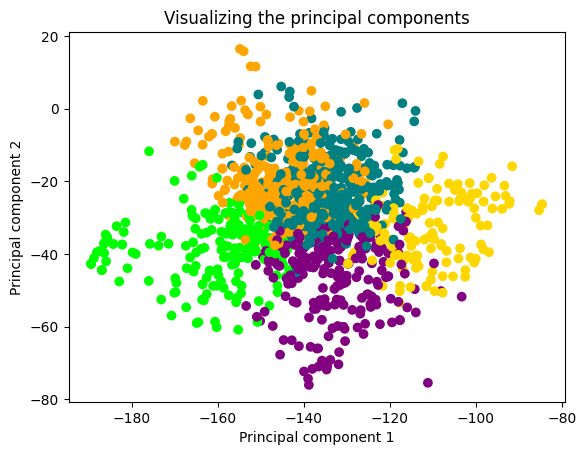

In [193]:
plt.scatter(x, y, c=colors)
plt.title(f'Visualizing the principal components')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()